In [39]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [40]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-03-17-00-55-52', '2024-03-17-10-41-24','2024-03-17-20-00-08']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [41]:
# crete a dataframe from runs and summary metrics
# async def add_max_to_summary(run):
#     try:
#         history: pd.DataFrame = run.history()
#         # get the row with the highest Self_Play/Mean_Reward
#         metric = "Self_Play/Mean_Reward"
#         best_row = history.loc[history[metric].idxmax()]
#         run.summary[f'max_{metric}'] = best_row[metric]
#         run.summary[f'max_{metric}_step'] = best_row['_step']
#         run.summary.update()
#     except:
#         pass



# async def get_history(run):
#     return await run.history()

# tasks = []
# for run in runs:
#     if run.state != "finished":
#         continue
#     tasks.append(add_max_to_summary(run))

# await asyncio.gather(*tasks)


data = []
for run in tqdm(runs):
    history: pd.DataFrame = run.history()
    for i, row in history.iterrows():
        # add a row to the data with run.config and the history row merged
        data.append({**run.config, **row})

df = pd.DataFrame(data)

df


100%|██████████| 168/168 [01:23<00:00,  2.01it/s]


,ncols,layers,puct_c,workers,lr_gamma,dir_alpha,env_params,eval_param,hidden_dim,iterations,...,Self_Play/Min_Return,Training/Regularization_loss,Self_Play/Max_Return,Self_Play/Mean_Entropy,Training/Policy_loss,Training/Replay_Buffer_Size,Self_Play/Mean_Return,_timestamp,Training/Value_loss,Self_Play/Min_Timesteps
0,8.0,5,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,64,30,...,0,274.604218,0,0.014798,1.455339,6,0.000000,1.710724e+09,0.000091,100
1,8.0,5,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,64,30,...,0,266.331696,0,0.000000,1.432775,12,0.000000,1.710724e+09,0.000041,100
2,8.0,5,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,64,30,...,0,258.301086,0,0.000000,1.422434,18,0.000000,1.710724e+09,0.000011,100
3,8.0,5,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,64,30,...,0,250.486771,0,0.034073,1.381317,24,0.000000,1.710724e+09,0.000002,100
4,8.0,5,1,1,1,2,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",10,64,30,...,0,242.874023,0,0.000000,1.374005,30,0.000000,1.710724e+09,0.000035,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,NaN,5,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",1,64,30,...,138,209.556641,154,0.137805,0.491662,60,146.333328,1.710636e+09,3.761225,138
5036,NaN,5,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",1,64,30,...,107,207.943558,123,0.272579,0.496769,60,116.333336,1.710636e+09,1.709903,107
5037,NaN,5,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",1,64,30,...,94,210.656494,136,0.052045,0.489779,60,112.000000,1.710636e+09,1.835788,94
5038,NaN,5,1,1,1,2,"{'id': 'CartPole-v1', 'max_episode_steps': 100...",1,64,30,...,106,214.721558,133,0.093565,0.475819,60,120.333336,1.710636e+09,3.501561,106


In [42]:
df.columns

Index(['ncols', 'layers', 'puct_c', 'workers', 'lr_gamma', 'dir_alpha',
       'env_params', 'eval_param', 'hidden_dim', 'iterations', 'model_type',
       'norm_layer', 'dir_epsilon', 'activation_fn', 'learning_rate',
       'discount_factor', 'env_description', 'planning_budget',
       'training_epochs', 'use_visit_count', 'n_steps_learning',
       'selection_policy', 'tree_temperature', 'value_loss_weight',
       'max_episode_length', 'policy_loss_weight', 'sample_batch_ratio',
       'tree_value_transform', 'observation_embedding',
       'regularization_weight', 'root_selection_policy',
       'episodes_per_iteration', 'tree_evaluation_policy',
       'replay_buffer_multiplier', 'selection_value_transform',
       'Self_Play/Entropies', 'Self_Play/Discounted_Return',
       'Self_Play/Mean_Timesteps', 'Self_Play/Timesteps', 'Self_Play/Returns',
       'Self_Play/Cumulative_Return', '_step',
       'Self_Play/Mean_Discounted_Return', 'Training/Value_Simularities',
       'Self_P

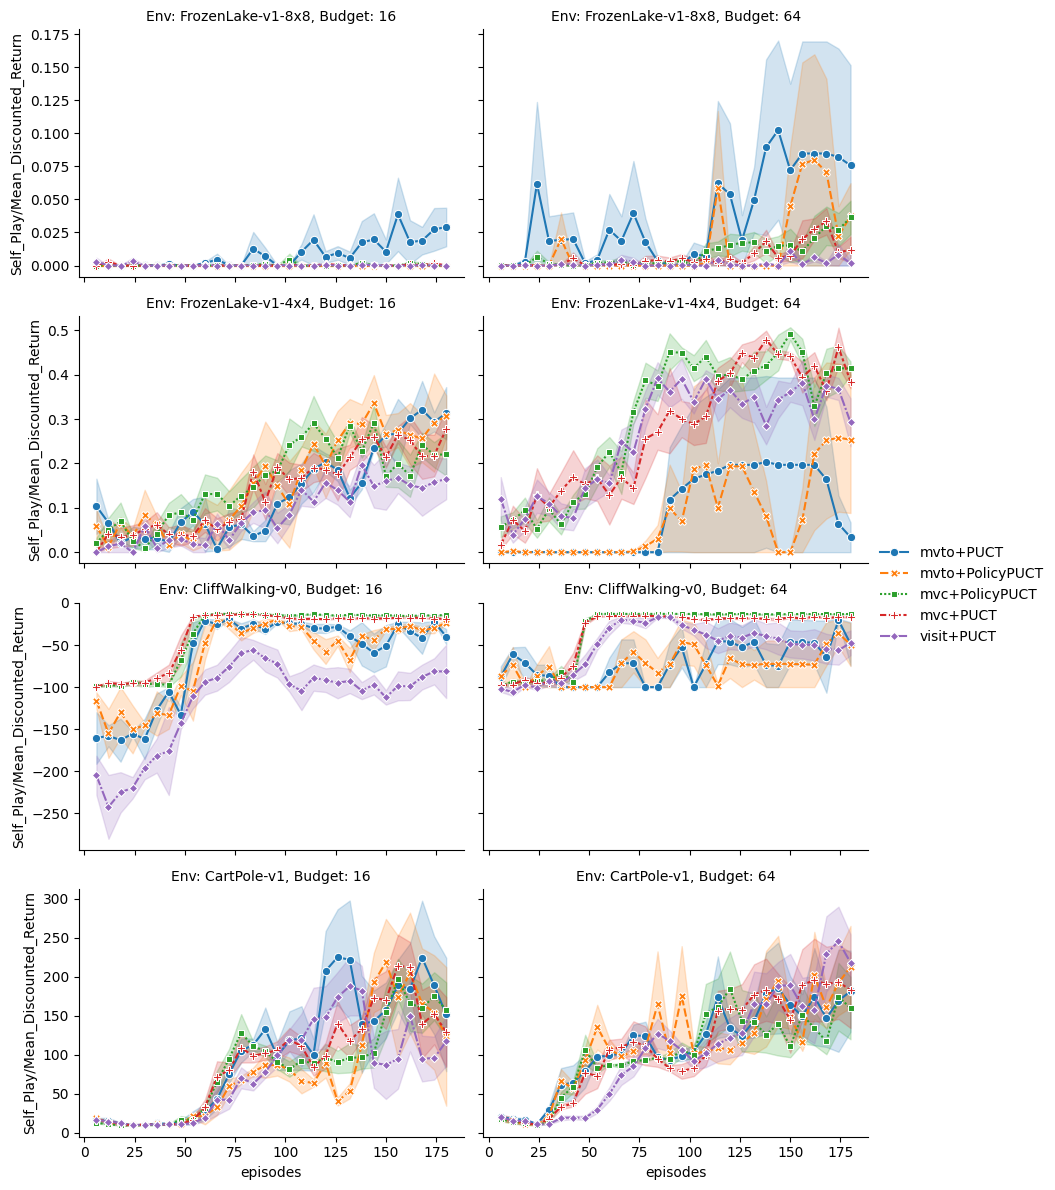

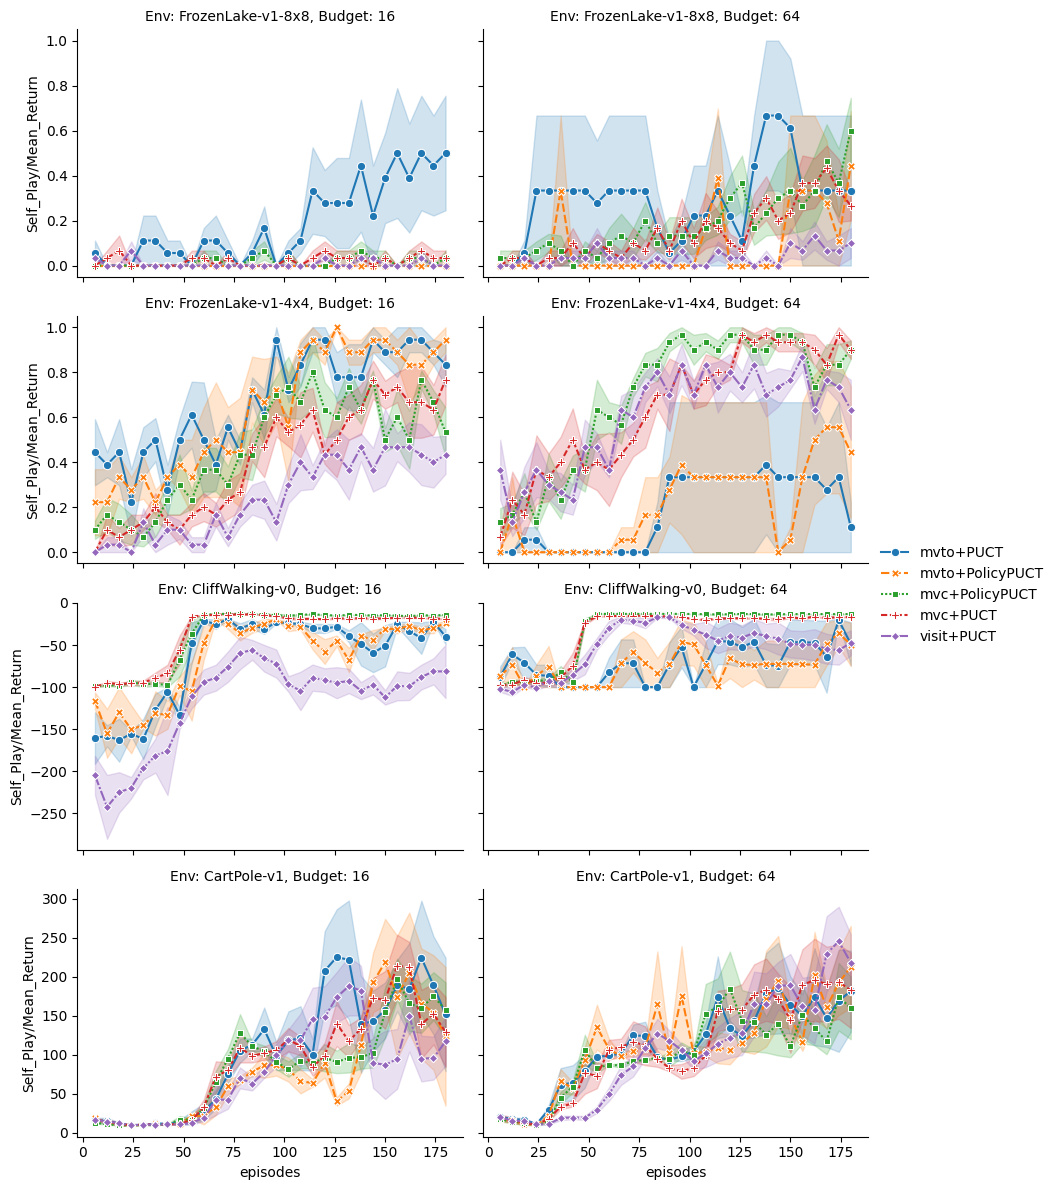

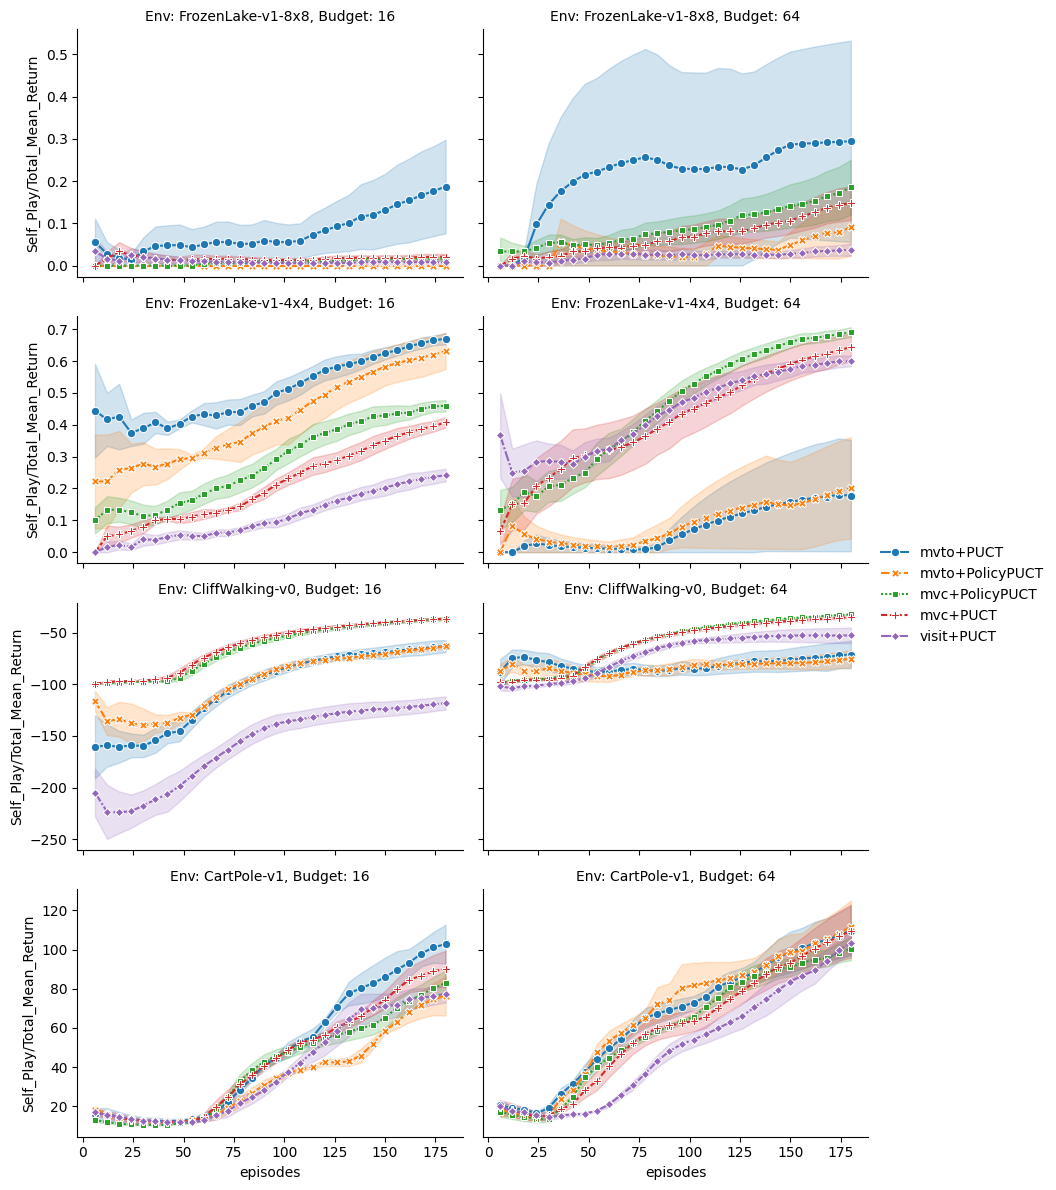

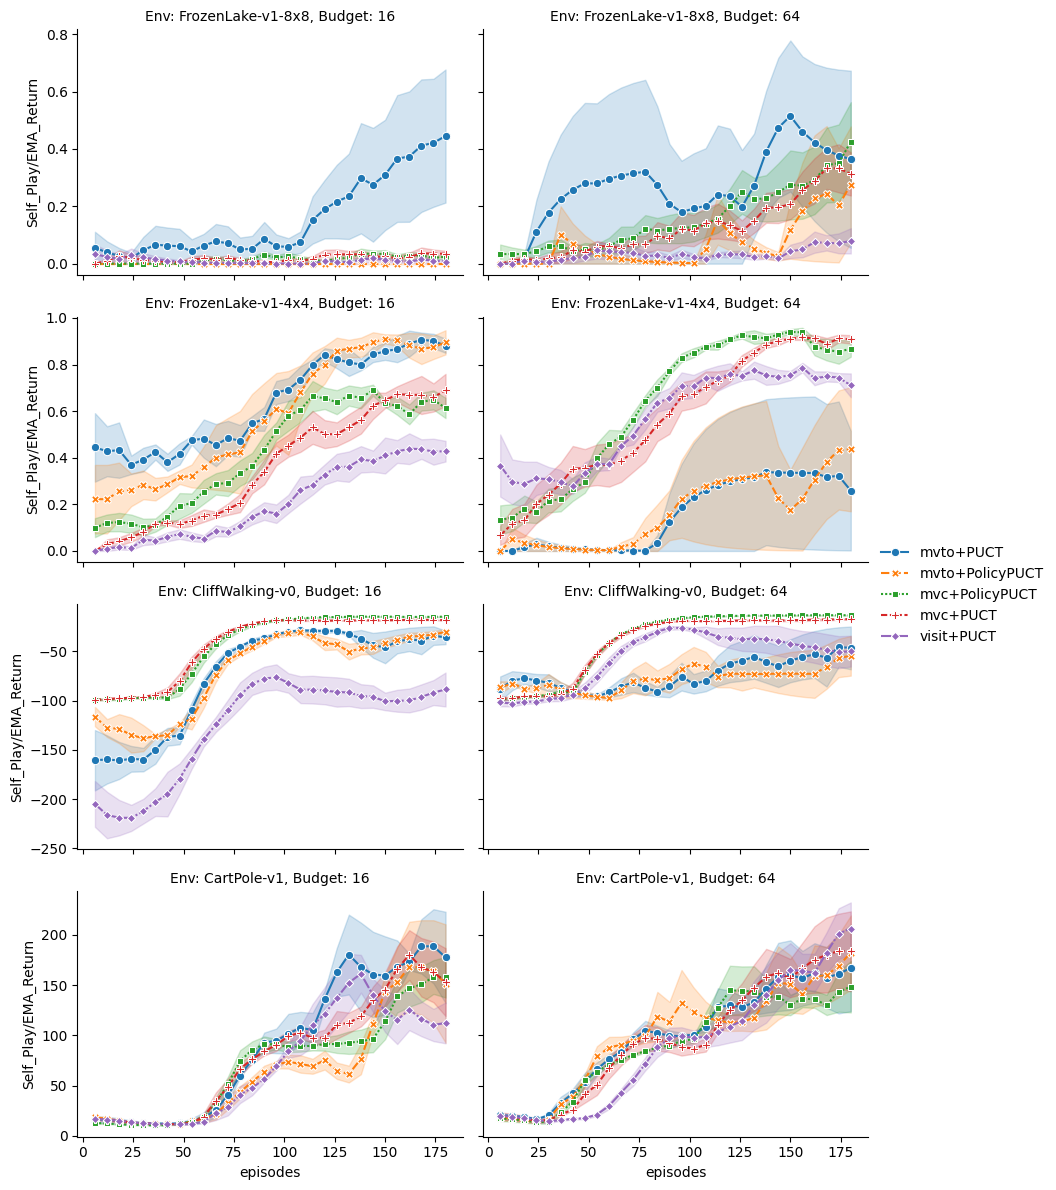

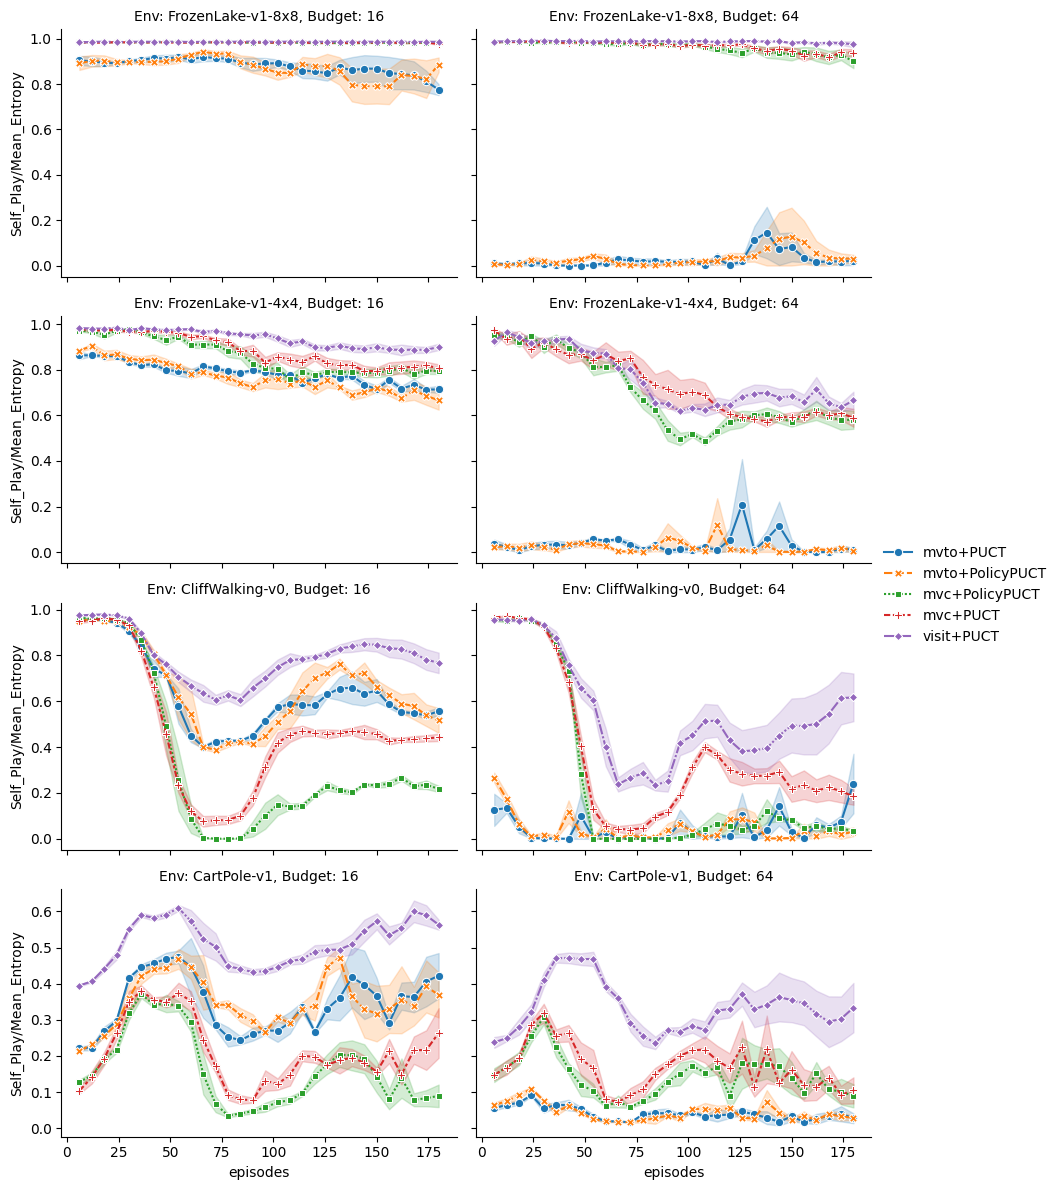

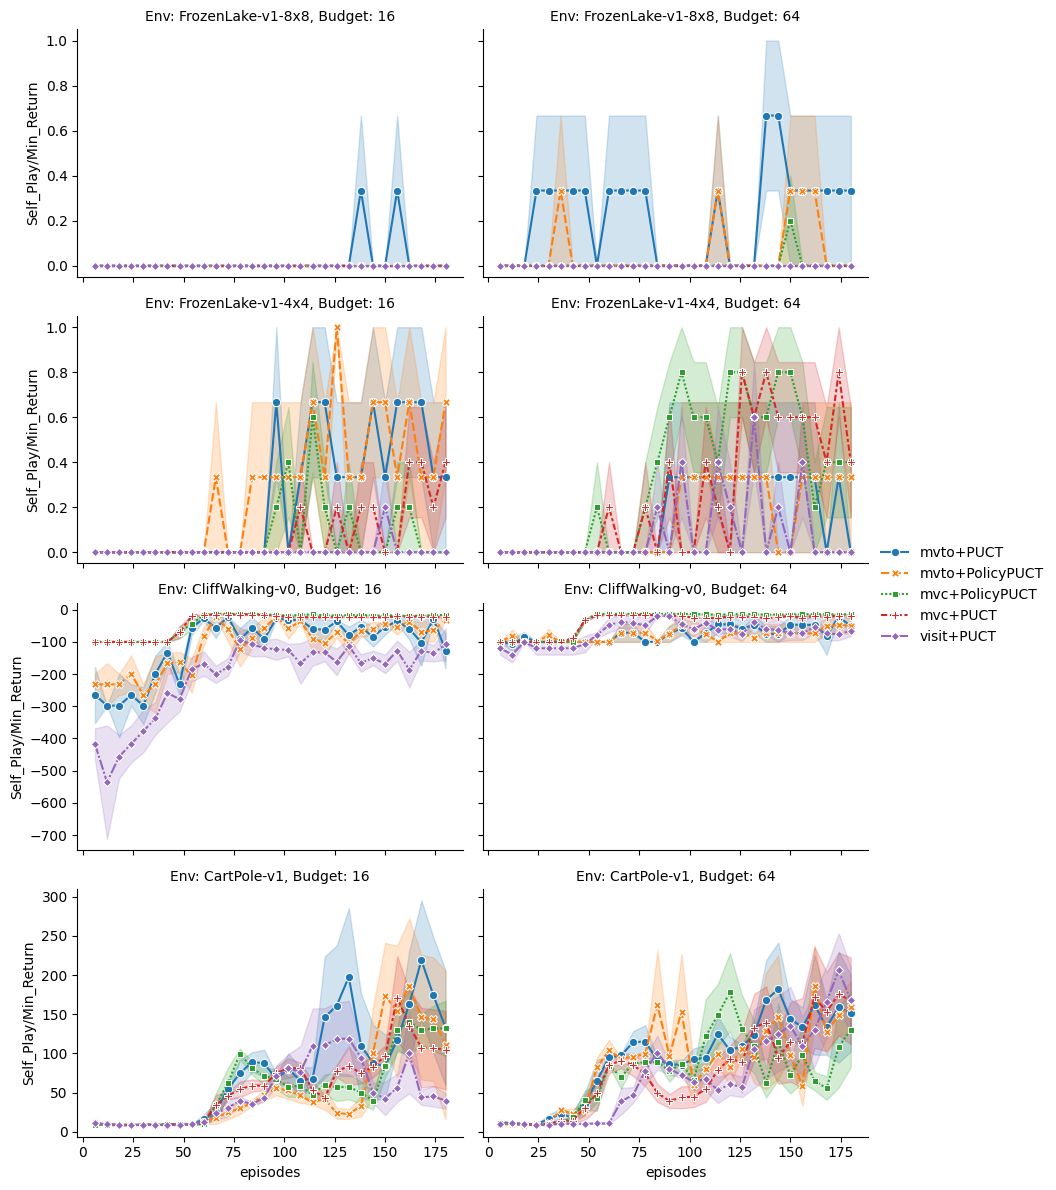

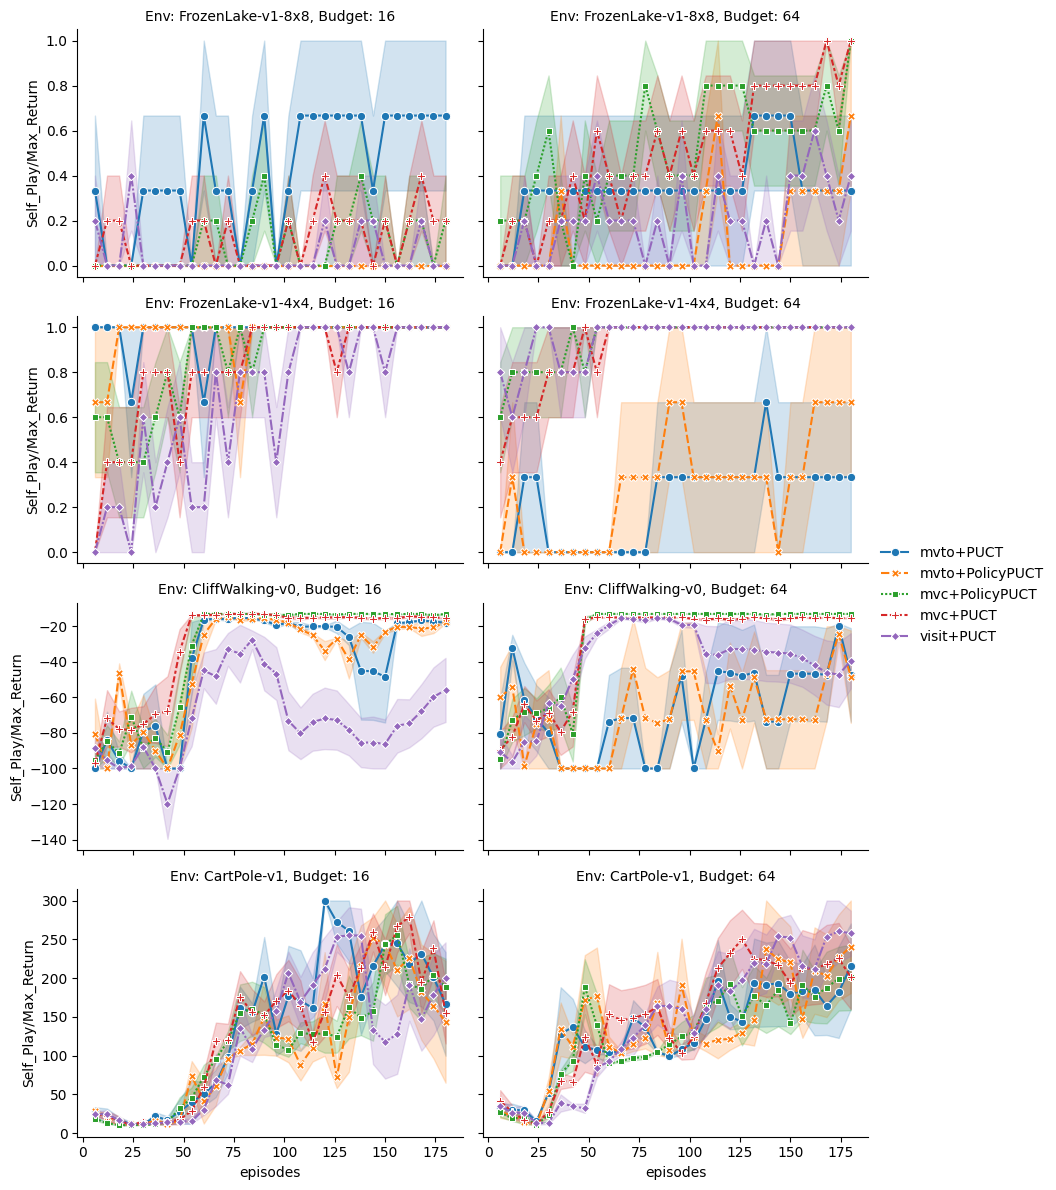

In [45]:


save_folder = 'outfiles'



df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Discounted_Return', 'Self_Play/Mean_Return', "Self_Play/Total_Mean_Return", "Self_Play/EMA_Return", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Return',
           'Self_Play/Max_Return',]
x_metric = "episodes"

estimator = "mean"

for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(data=df, row="env_description", col="planning_budget", sharex="col", sharey="row", aspect=1.5)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed


    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()
    g.set_titles("Env: {row_name}, Budget: {col_name}")


    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)
    # increase the width of the plot
    # g.fig.set_figwidth(10)
    # plt.suptitle(metric)
    # plt.tight_layout()
    plt.show()